### Inizializzazione del contesto Spark

In [1]:
import pyspark
sc = pyspark.SparkContext()

In [2]:
import matplotlib.pyplot as plt
from collections import OrderedDict
from pyspark.sql.functions import when, lit, avg, exp, col, UserDefinedFunction
import seaborn as sns
from pyspark.mllib.stat import Statistics
import pandas as pd
import pyspark.sql.functions as F
import copy
from pyspark.sql import Row, Column
from plotnine import *
from pyspark.sql.types import StringType, IntegerType
import plotly.graph_objects as go
import numpy as np

### Istanziamo una sessione spark con il "builder()"
- getOrCreate() Per accedere alla sessione spark corrente (o crearne una nuova se non ce ne sono attive)

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField
spark = SparkSession.builder \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

### Path del File

In [4]:
hdfs_path = "hdfs://kddrtserver13.isti.cnr.it:9000/user/hpsa15/bank-additional-full.csv"

### Lettura del csv come DataFrame - con inferenza schema automatica

In [5]:
kdd_df = spark.read.options(inferSchema = True, delimiter = ';', header = True).csv(hdfs_path)

In [6]:
kdd_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp.var.rate: double (nullable = true)
 |-- cons.price.idx: double (nullable = true)
 |-- cons.conf.idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr.employed: double (nullable = true)
 |-- y: string (nullable = true)



In [7]:
kdd_df.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('month', 'string'),
 ('day_of_week', 'string'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('emp.var.rate', 'double'),
 ('cons.price.idx', 'double'),
 ('cons.conf.idx', 'double'),
 ('euribor3m', 'double'),
 ('nr.employed', 'double'),
 ('y', 'string')]

In [8]:
kdd_df = kdd_df.withColumnRenamed("emp.var.rate","emp_var_rate").withColumnRenamed("cons.price.idx","cons_price_idx")
kdd_df = kdd_df.withColumnRenamed("cons.conf.idx","cons_conf_idx").withColumnRenamed("nr.employed","nr_employed")

In [9]:
kdd_df

DataFrame[age: int, job: string, marital: string, education: string, default: string, housing: string, loan: string, contact: string, month: string, day_of_week: string, duration: int, campaign: int, pdays: int, previous: int, poutcome: string, emp_var_rate: double, cons_price_idx: double, cons_conf_idx: double, euribor3m: double, nr_employed: double, y: string]

## Drop righe duplicate

In [10]:
not_duplicated_df = kdd_df.distinct()
print("Distinct count: " + str(not_duplicated_df.count()))

Distinct count: 41176


### Lettura come RDD

In [12]:
kdd_rdd = sc.textFile(hdfs_path)

In [13]:
p = kdd_rdd.collect() 

In [14]:
p

['"age";"job";"marital";"education";"default";"housing";"loan";"contact";"month";"day_of_week";"duration";"campaign";"pdays";"previous";"poutcome";"emp.var.rate";"cons.price.idx";"cons.conf.idx";"euribor3m";"nr.employed";"y"',
 '56;"housemaid";"married";"basic.4y";"no";"no";"no";"telephone";"may";"mon";261;1;999;0;"nonexistent";1.1;93.994;-36.4;4.857;5191;"no"',
 '57;"services";"married";"high.school";"unknown";"no";"no";"telephone";"may";"mon";149;1;999;0;"nonexistent";1.1;93.994;-36.4;4.857;5191;"no"',
 '37;"services";"married";"high.school";"no";"yes";"no";"telephone";"may";"mon";226;1;999;0;"nonexistent";1.1;93.994;-36.4;4.857;5191;"no"',
 '40;"admin.";"married";"basic.6y";"no";"no";"no";"telephone";"may";"mon";151;1;999;0;"nonexistent";1.1;93.994;-36.4;4.857;5191;"no"',
 '56;"services";"married";"high.school";"no";"no";"yes";"telephone";"may";"mon";307;1;999;0;"nonexistent";1.1;93.994;-36.4;4.857;5191;"no"',
 '45;"services";"married";"basic.9y";"unknown";"no";"no";"telephone";"may

### 1) Azioni sull'RDD

- Conteggio del numero di record dataset originale

In [15]:
#la prima riga è l'header
kdd_rdd.count()-1 

41188

- Separazione dall'header dataset nuovo

In [16]:
kdd_rdd_header = kdd_rdd.first()
# Sostituiamo "." con "_" perchè potrebbe dare problemi
kdd_rdd_header = kdd_rdd_header.replace(".", "_")

In [17]:
firs_feature = kdd_rdd_header.split(";")[0]

In [18]:
kdd_rdd_no_header = kdd_rdd.filter(lambda row: firs_feature not in row)

In [19]:
kdd_rdd_no_header.collect()

['56;"housemaid";"married";"basic.4y";"no";"no";"no";"telephone";"may";"mon";261;1;999;0;"nonexistent";1.1;93.994;-36.4;4.857;5191;"no"',
 '57;"services";"married";"high.school";"unknown";"no";"no";"telephone";"may";"mon";149;1;999;0;"nonexistent";1.1;93.994;-36.4;4.857;5191;"no"',
 '37;"services";"married";"high.school";"no";"yes";"no";"telephone";"may";"mon";226;1;999;0;"nonexistent";1.1;93.994;-36.4;4.857;5191;"no"',
 '40;"admin.";"married";"basic.6y";"no";"no";"no";"telephone";"may";"mon";151;1;999;0;"nonexistent";1.1;93.994;-36.4;4.857;5191;"no"',
 '56;"services";"married";"high.school";"no";"no";"yes";"telephone";"may";"mon";307;1;999;0;"nonexistent";1.1;93.994;-36.4;4.857;5191;"no"',
 '45;"services";"married";"basic.9y";"unknown";"no";"no";"telephone";"may";"mon";198;1;999;0;"nonexistent";1.1;93.994;-36.4;4.857;5191;"no"',
 '59;"admin.";"married";"professional.course";"no";"no";"no";"telephone";"may";"mon";139;1;999;0;"nonexistent";1.1;93.994;-36.4;4.857;5191;"no"',
 '41;"blue-c

In [20]:
kdd_rdd_no_header.count()

41188

In [21]:
# Features:
len(kdd_rdd_header.split(";"))

21

In [22]:
kdd_rdd_no_header.collect()[0]

'56;"housemaid";"married";"basic.4y";"no";"no";"no";"telephone";"may";"mon";261;1;999;0;"nonexistent";1.1;93.994;-36.4;4.857;5191;"no"'

### 2) Studio attributi categorici: conteggio valori in ordine decrescente:
(nome, posizione):
- job, 1
- marital, 2
- education, 3
- default, 4
- housing, 5
- loan, 6
- contact, 7
- month, 8
- day_of_week, 9
- poutcome, 14

In [26]:
# Funzione per contare le occorrenze in ordine decrescente
def counter_by_labels(labels_list):
    for i in labels_list:
        labels = kdd_rdd_no_header.map(lambda line: line.strip().split(";")[i[1]])
        label_counts = labels.countByValue()
        sorted_labels = OrderedDict(sorted(label_counts.items(), key=lambda t: t[1], reverse=True))
        print("Count value for <" + str(i[0]) + ">: value - count")
        all_c = 0
        for label, count in sorted_labels.items():
            print("   " + str(label) + " - " + str(count))
            all_c = all_c + count

In [27]:
labels_list = [("Job", 1), ("Marital", 2), 
               ("Education", 3), ("Default", 4),
               ("Housing", 5), ("Loan", 6),
               ("Contact", 7), ("Month", 8),
               ("Day_of_week", 9), ("Poutcome", 14)
            ]
counter_by_labels(labels_list)

Count value for <Job>: value - count
   "admin." - 10422
   "blue-collar" - 9254
   "technician" - 6743
   "services" - 3969
   "management" - 2924
   "retired" - 1720
   "entrepreneur" - 1456
   "self-employed" - 1421
   "housemaid" - 1060
   "unemployed" - 1014
   "student" - 875
   "unknown" - 330
Count value for <Marital>: value - count
   "married" - 24928
   "single" - 11568
   "divorced" - 4612
   "unknown" - 80
Count value for <Education>: value - count
   "university.degree" - 12168
   "high.school" - 9515
   "basic.9y" - 6045
   "professional.course" - 5243
   "basic.4y" - 4176
   "basic.6y" - 2292
   "unknown" - 1731
   "illiterate" - 18
Count value for <Default>: value - count
   "no" - 32588
   "unknown" - 8597
   "yes" - 3
Count value for <Housing>: value - count
   "yes" - 21576
   "no" - 18622
   "unknown" - 990
Count value for <Loan>: value - count
   "no" - 33950
   "yes" - 6248
   "unknown" - 990
Count value for <Contact>: value - count
   "cellular" - 26144
   "tele

### 3) Studio target:

In [28]:
counter_by_labels([("Target y", -1)])

Count value for <Target y>: value - count
   "no" - 36548
   "yes" - 4640


### 4) Queries sul dataframe:

In [29]:
not_duplicated_df.show()

+---+------------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|         job| marital|          education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+------------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 42|      admin.| married|  university.degree|     no|     no| yes|telephone|  may|        mon|     262|       2|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 49| blue-collar| married|        high.school|unknown|     no|  no|telephone|  may|        tue|      69|       1|  999|       0|nonexistent|         1.1|      

In [23]:
# Esempio distinct
not_duplicated_df.select("job").distinct().show()

+-------------+
|          job|
+-------------+
|   management|
|      retired|
|      unknown|
|self-employed|
|      student|
|  blue-collar|
| entrepreneur|
|       admin.|
|   technician|
|     services|
|    housemaid|
|   unemployed|
+-------------+



In [31]:
# Creazione vista temporanea "temp"
not_duplicated_df.createOrReplaceTempView("temp")

In [32]:
query = spark.sql("SELECT job, count(*) FROM temp GROUP BY job")
query.show()

+-------------+--------+
|          job|count(1)|
+-------------+--------+
|   management|    2924|
|      retired|    1718|
|      unknown|     330|
|self-employed|    1421|
|      student|     875|
|  blue-collar|    9253|
| entrepreneur|    1456|
|       admin.|   10419|
|   technician|    6739|
|     services|    3967|
|    housemaid|    1060|
|   unemployed|    1014|
+-------------+--------+



In [33]:
query = spark.sql("SELECT month, nr_employed, count(*) AS tot FROM temp GROUP BY month, nr_employed")
query.show()

+-----+-----------+----+
|month|nr_employed| tot|
+-----+-----------+----+
|  apr|     5099.1|2457|
|  oct|     5195.8|  67|
|  jul|     5076.2| 177|
|  nov|     5195.8|3615|
|  mar|     5099.1| 282|
|  sep|     4963.6| 303|
|  oct|     5017.5| 446|
|  oct|     4963.6| 204|
|  jun|     5076.2| 715|
|  jul|     4991.6| 311|
|  may|     5191.0|7762|
|  jun|     5228.1|4374|
|  apr|     5008.7| 174|
|  may|     5099.1|5793|
|  sep|     5017.5| 267|
|  jul|     5228.1|6681|
|  aug|     5228.1|5173|
|  aug|     5076.2| 770|
|  mar|     5008.7| 264|
|  nov|     4963.6| 128|
+-----+-----------+----+
only showing top 20 rows



In [34]:
query.createOrReplaceTempView("temp1")
query = spark.sql("SELECT month, SUM(tot) FROM temp1 GROUP BY month, tot")
query.show()

+-----+--------+
|month|sum(tot)|
+-----+--------+
|  sep|     303|
|  aug|     770|
|  apr|    2457|
|  dec|      10|
|  mar|     282|
|  may|     212|
|  jun|     229|
|  sep|     267|
|  aug|    5173|
|  aug|     233|
|  nov|     357|
|  nov|    3615|
|  jul|    6681|
|  jun|     715|
|  oct|     446|
|  oct|     204|
|  nov|     128|
|  mar|     264|
|  dec|     172|
|  jul|     311|
+-----+--------+
only showing top 20 rows



In [35]:
query = spark.sql("SELECT y, count(*) FROM temp WHERE duration =0 GROUP BY y")
query.show()

+---+--------+
|  y|count(1)|
+---+--------+
| no|       4|
+---+--------+



In [36]:
# Creazione vista temporanea "temp"
not_duplicated_df.createOrReplaceTempView("temp2")

Numero di chiamate precedente campagna

In [37]:
query1 = spark.sql("""SELECT COUNT(*) FROM temp2""")
query1.show()

+--------+
|count(1)|
+--------+
|   41176|
+--------+



In [38]:
query2 = spark.sql(""" SELECT COUNT(*)/41188 * 100 AS prev_tot FROM temp2 WHERE previous > 0""")

In [39]:
query2.show()

+-----------------+
|         prev_tot|
+-----------------+
|13.65689035641449|
+-----------------+



Numero di chiamate questa campagna

In [40]:
query2 = spark.sql(""" SELECT COUNT(*)/41188 * 100 AS camp_tot FROM temp2 WHERE campaign > 1""")
query2.show()

+------------------+
|          camp_tot|
+------------------+
|57.157424492570655|
+------------------+



Numero di coincidenze tra campaign>1 e previous>0

In [41]:
query2 = spark.sql(""" SELECT COUNT(*)/41188 * 100 AS camp_tot FROM temp2 WHERE campaign > 1 AND previous > 0""")
query2.show()

+-----------------+
|         camp_tot|
+-----------------+
|6.734971350878896|
+-----------------+



In [42]:
query2 = spark.sql(""" SELECT y FROM temp2 WHERE campaign > 1 AND previous > 0""")
query2.show()

+---+
|  y|
+---+
| no|
| no|
| no|
| no|
| no|
| no|
| no|
| no|
| no|
| no|
| no|
| no|
| no|
| no|
| no|
| no|
|yes|
| no|
| no|
| no|
+---+
only showing top 20 rows



In [43]:
query2 = spark.sql(""" SELECT COUNT(*) FROM temp2 WHERE campaign > 1 AND previous > 0 GROUP BY y""")
query2.show()

+--------+
|count(1)|
+--------+
|    2084|
|     690|
+--------+



In [44]:
query2 = spark.sql(""" SELECT COUNT(*) FROM temp2 WHERE campaign = 1 AND previous = 0 GROUP BY y""")
query2.show()
query2 = spark.sql(""" SELECT COUNT(*) FROM temp2 WHERE campaign = 1 GROUP BY y""")
query2.show()

+--------+
|count(1)|
+--------+
|   13293|
|    1490|
+--------+

+--------+
|count(1)|
+--------+
|   15335|
|    2299|
+--------+



Percentuale di yes/no

In [45]:
query2 = spark.sql(""" SELECT COUNT(*) FROM temp2 GROUP BY y""")
query2.show()


+--------+
|count(1)|
+--------+
|   36537|
|    4639|
+--------+



In [46]:
condition1 = (not_duplicated_df.job=="unknown") | (not_duplicated_df.education=="unknown")
condition2 = not_duplicated_df.y== "yes"
kdd_df2 = not_duplicated_df.filter(condition1).filter(condition2)

In [47]:
kdd_df2.show(truncate=False)

+---+------------+--------+---------+-------+-------+-------+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|job         |marital |education|default|housing|loan   |contact  |month|day_of_week|duration|campaign|pdays|previous|poutcome   |emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|y  |
+---+------------+--------+---------+-------+-------+-------+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|60 |retired     |married |unknown  |no     |yes    |no     |cellular |aug  |mon        |600     |2       |999  |0       |nonexistent|1.4         |93.444        |-36.1        |4.965    |5228.1     |yes|
|55 |entrepreneur|single  |unknown  |unknown|no     |no     |telephone|jul  |wed        |542     |1       |999  |0       |nonexistent|1.4         |93.918        |-42.7        |4.963    |52

Esempio selezione distinti

In [48]:
not_duplicated_df.select("job").distinct().rdd.map(lambda r: r[0]).collect()
# - Select(class_name) funzione per selezionare una o più colonne per fare un'operazione
# - Distinct() usata su una colonna pysparl indica i valori univoci
# - rdd indica che il dataframe è un RDD (Resilient Distributed Dataset) = raccolta di elementi non modificabile e partizionata su cui è possibile operare in parallelo. 
# - map(function)  utilizzata per trasformare l'rdd utilizzando una funzione lambda.

['management',
 'retired',
 'unknown',
 'self-employed',
 'student',
 'blue-collar',
 'entrepreneur',
 'admin.',
 'technician',
 'services',
 'housemaid',
 'unemployed']

# Modifiche Dataset

- Sostituzione in pdays dei valori pari a "999" con "-1"

In [24]:
target_column = "pdays"

In [25]:
not_duplicated_df = not_duplicated_df.withColumn(target_column,
    F.when(not_duplicated_df[target_column]==999,-1).
    otherwise(not_duplicated_df[target_column]))

- Drop duration = 0

In [26]:
target_column = "duration"

In [27]:
not_duplicated_df = not_duplicated_df.filter(not_duplicated_df[target_column] != 0)

In [28]:
not_duplicated_df.count()

41172

# Salvataggio nuovo dataset

In [30]:
not_duplicated_df.write.format("csv").save("hdfs://kddrtserver13.isti.cnr.it:9000/user/hpsa15/bank_dataset2.csv", header = True)

In [31]:
hdfs_path2 = 'hdfs://kddrtserver13.isti.cnr.it:9000/user/hpsa15/bank_dataset2.csv'

In [32]:
kdd_df_new2 = spark.read.options(inferSchema = True, header = True).csv(hdfs_path2)

In [38]:
kdd_df_new2.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('month', 'string'),
 ('day_of_week', 'string'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('emp_var_rate', 'double'),
 ('cons_price_idx', 'double'),
 ('cons_conf_idx', 'double'),
 ('euribor3m', 'double'),
 ('nr_employed', 'double'),
 ('y', 'string')]

# Statistiche variabili numeriche

In [54]:
def basic_statistics(df):
    for i in df.dtypes:
        if(i[1] == 'int' or i[1] == 'double'):
            df.describe(i[0]).show(truncate=False)

- dataset originale

In [55]:
basic_statistics(kdd_df)

+-------+------------------+
|summary|age               |
+-------+------------------+
|count  |41188             |
|mean   |40.02406040594348 |
|stddev |10.421249980934057|
|min    |17                |
|max    |98                |
+-------+------------------+

+-------+------------------+
|summary|duration          |
+-------+------------------+
|count  |41188             |
|mean   |258.2850101971448 |
|stddev |259.27924883646455|
|min    |0                 |
|max    |4918              |
+-------+------------------+

+-------+-----------------+
|summary|campaign         |
+-------+-----------------+
|count  |41188            |
|mean   |2.567592502670681|
|stddev |2.770013542902331|
|min    |1                |
|max    |56               |
+-------+-----------------+

+-------+-----------------+
|summary|pdays            |
+-------+-----------------+
|count  |41188            |
|mean   |962.4754540157328|
|stddev |186.9109073447414|
|min    |0                |
|max    |999              |

- dataset modificato

In [56]:
basic_statistics(not_duplicated_df)

+-------+------------------+
|summary|age               |
+-------+------------------+
|count  |41172             |
|mean   |40.02326824055183 |
|stddev |10.420474048540774|
|min    |17                |
|max    |98                |
+-------+------------------+

+-------+-----------------+
|summary|duration         |
+-------+-----------------+
|count  |41172            |
|mean   |258.340911298941 |
|stddev |259.3054156925593|
|min    |1                |
|max    |4918             |
+-------+-----------------+

+-------+------------------+
|summary|campaign          |
+-------+------------------+
|count  |41172             |
|mean   |2.567667346740503 |
|stddev |2.7701995342345733|
|min    |1                 |
|max    |56                |
+-------+------------------+

+-------+-------------------+
|summary|pdays              |
+-------+-------------------+
|count  |41172              |
|mean   |-0.7418876906635578|
|stddev |1.51061147003449   |
|min    |-1                 |
|max    |27  

# Distribuzione variabile target per categorici

- Contact

In [57]:
def distr_target(df, target_columns):
    df.createOrReplaceTempView("temp")
    tot = {}
    for target_column in target_columns:
        query = spark.sql("SELECT "+ target_column + ", y, COUNT(*) AS Tot FROM temp GROUP BY "+ target_column + ", y")
        #query.show()
        dist_val = spark.sql("SELECT DISTINCT "+ target_column + " FROM temp" )
        #dist_val.show()
        dist_val = dist_val.select(target_column).rdd.map(lambda r: r[0]).collect()
        for i in dist_val:
            #print(i)
            y_ = query.filter(df[target_column] == i).filter(df["y"]=="yes").select("Tot").rdd.map(lambda r: r[0]).collect()[0]
            n_ = query.filter(df[target_column] == i).filter(df["y"]=="no").select("Tot").rdd.map(lambda r: r[0]).collect()[0]
            tot[target_column + "_"+i] = y_/n_
    return tot 

In [58]:
distr_target(not_duplicated_df, ["contact"])

{'contact_cellular': 0.17289048473967683,
 'contact_telephone': 0.05521644566056269}

- Risultato y rispetto a campagna precedente

In [59]:
def cond_perc(df, target_columns):
    df.createOrReplaceTempView("temp")
    tot = {}
    for target_column in target_columns:
        query = spark.sql("SELECT "+ target_column + ", y, COUNT(*) AS Tot FROM temp GROUP BY "+ target_column + ", y")
        #query.show()
        dist_val = spark.sql("SELECT DISTINCT "+ target_column + " FROM temp" )
        #dist_val.show()
        dist_val = dist_val.select(target_column).rdd.map(lambda r: r[0]).collect()
        for i in dist_val:
            #print(i)
            y_ = query.filter(df[target_column] == i).filter(df["y"]=="yes").select("Tot").rdd.map(lambda r: r[0]).collect()[0]
            n_ = query.filter(df[target_column] == i).filter(df["y"]=="no").select("Tot").rdd.map(lambda r: r[0]).collect()[0]
            tot[target_column + "_"+i + "_yes"] = [y_/(y_+n_)*100, y_]
            tot[target_column + "_"+i + "_no"] = [n_/(y_+n_)*100, n_]
    return tot 

In [60]:
cond_perc(not_duplicated_df, ["poutcome"])

{'poutcome_success_yes': [65.1128914785142, 894],
 'poutcome_success_no': [34.8871085214858, 479],
 'poutcome_failure_yes': [14.22859830667921, 605],
 'poutcome_failure_no': [85.7714016933208, 3647],
 'poutcome_nonexistent_yes': [8.833375530987144, 3140],
 'poutcome_nonexistent_no': [91.16662446901286, 32407]}

# Numero di anziani con yes (e no) e durata della loro chiamata

In [46]:
not_duplicated_df.createOrReplaceTempView("temp_1")

In [50]:
my = spark.sql("SELECT age, duration FROM temp_1 WHERE y = 'yes' AND age > 70 AND duration < 100")
my.show()
my.count()

+---+--------+
|age|duration|
+---+--------+
| 73|      63|
| 78|      87|
| 72|      87|
+---+--------+



3

In [51]:
my = spark.sql("SELECT age, duration FROM temp_1 WHERE y = 'no' AND age < 100")
my.show()
my.count()

+---+--------+
|age|duration|
+---+--------+
| 42|     262|
| 49|      69|
| 45|     129|
| 45|     477|
| 36|     208|
| 47|     298|
| 48|     166|
| 43|     124|
| 52|     833|
| 29|     260|
| 24|     246|
| 28|     117|
| 59|     341|
| 34|     135|
| 31|     582|
| 48|     202|
| 32|     177|
| 33|     290|
| 35|     408|
| 39|       5|
+---+--------+
only showing top 20 rows



36533

## Plot

Identifichiamo il mese dell'anno con la coppia "month_year"

In [61]:
not_duplicated_df.select("month").groupby("month").count().show()

+-----+-----+
|month|count|
+-----+-----+
|  jun| 5318|
|  aug| 6175|
|  may|13765|
|  sep|  570|
|  mar|  546|
|  oct|  717|
|  jul| 7169|
|  nov| 4100|
|  apr| 2630|
|  dec|  182|
+-----+-----+



In [62]:
not_duplicated_df.select("month").filter(not_duplicated_df["month"]=="mar").groupby("month").count().show()

+-----+-----+
|month|count|
+-----+-----+
|  mar|  546|
+-----+-----+



In [63]:
kdd_df.select("month").filter(kdd_df["month"]=="mar").groupby("month").count().show()

+-----+-----+
|month|count|
+-----+-----+
|  mar|  546|
+-----+-----+



In [64]:
def insert_year(df):
    month = df.rdd.map(lambda x: x.month).collect()
    d = []
    year = 2008
    count = 0
    idx = 10
    tmp = month[0]
    for i in range(0, len(month)):
        if (month[i] != tmp) or (i==(len(month)-1)):
            if(i==(len(month)-1)):
                count = count + 1
            for j in range(0, count):
                #d.append(tmp+"_" + str(year))
                d.append((idx, str(year)+"_"+tmp))
            #print("Mese = " + str(tmp)+"_" + str(year) + "--- Count = " + str(count))
            tmp = month[i]
            idx = idx + 1
            count = 1
            if month[i]=="mar":
                year= year + 1
                
        else:
            count = count + 1
    rdd = sc.parallelize(d)
    month_year = rdd.map(lambda x: Row(idx = x[0], month_year= x[1]))
    df_month_year = spark.createDataFrame(month_year)
    return df_month_year

In [65]:
df_month_year= insert_year(kdd_df)

Selezione colonne

In [67]:
# Splittiamo in due liste chiave, valore per fare plot
def split_k_v(query):
    return query.rdd.map(lambda x: x[1]).collect(),query.rdd.map(lambda x: x[2]).collect() 

- Mesi ed anni + count

In [68]:
df_month_year.createOrReplaceTempView("temp_my")

In [69]:
my = spark.sql("SELECT idx, month_year, count(*) AS tot FROM temp_my GROUP BY idx, month_year ORDER BY idx")
my.show()

+---+----------+----+
|idx|month_year| tot|
+---+----------+----+
| 10|  2008_may|7763|
| 11|  2008_jun|4374|
| 12|  2008_jul|6685|
| 13|  2008_aug|5175|
| 14|  2008_oct|  67|
| 15|  2008_nov|3616|
| 16|  2008_dec|  10|
| 17|  2009_mar| 282|
| 18|  2009_apr|2458|
| 19|  2009_may|5794|
| 20|  2009_jun| 715|
| 21|  2009_jul| 178|
| 22|  2009_aug| 770|
| 23|  2009_sep| 267|
| 24|  2009_oct| 447|
| 25|  2009_nov| 357|
| 26|  2009_dec| 172|
| 27|  2010_mar| 264|
| 28|  2010_apr| 174|
| 29|  2010_may| 212|
+---+----------+----+
only showing top 20 rows



- Mese_anno vs Campagna precedente

In [71]:
month_year = df_month_year.rdd.map(lambda x: x.month_year).collect()

In [72]:
poutcome = kdd_df.rdd.map(lambda x: x.poutcome).collect()

In [73]:
y = kdd_df.rdd.map(lambda x: x.y).collect()

In [74]:
euribor3m = kdd_df.rdd.map(lambda x: x.euribor3m).collect()

In [75]:
ll = []
idx_m = 10
for i in range(0, len(month_year)):
    ll.append((idx_m, month_year[i], poutcome[i], y[i]))
    if i != (len(month_year)-1):
        #if month_year[i+1] != month_year[i]:
        if month_year[i+1] != month_year[i]:
            idx_m = idx_m + 1
rdd = sc.parallelize(ll)
tmp = rdd.map(lambda x: Row(idx_m = x[0], month_year = x[1], poutcome= x[2], y=x[3]))
tmp_dd = spark.createDataFrame(tmp)

In [76]:
tmp_dd.createOrReplaceTempView("temp_")

In [77]:
query = spark.sql("SELECT idx_m, month_year, poutcome, y, count(*) AS tot FROM temp_ GROUP BY idx_m,  month_year, poutcome, y ORDER BY idx_m, poutcome")
query.show()

+-----+----------+-----------+---+----+
|idx_m|month_year|   poutcome|  y| tot|
+-----+----------+-----------+---+----+
|   10|  2008_may|nonexistent|yes| 240|
|   10|  2008_may|nonexistent| no|7523|
|   11|  2008_jun|nonexistent|yes| 188|
|   11|  2008_jun|nonexistent| no|4186|
|   12|  2008_jul|nonexistent|yes| 407|
|   12|  2008_jul|nonexistent| no|6278|
|   13|  2008_aug|nonexistent|yes| 271|
|   13|  2008_aug|nonexistent| no|4904|
|   14|  2008_oct|    failure| no|   1|
|   14|  2008_oct|    failure|yes|   1|
|   14|  2008_oct|nonexistent|yes|  41|
|   14|  2008_oct|nonexistent| no|  24|
|   15|  2008_nov|    failure| no| 673|
|   15|  2008_nov|    failure|yes|  23|
|   15|  2008_nov|nonexistent| no|2721|
|   15|  2008_nov|nonexistent|yes| 164|
|   15|  2008_nov|    success|yes|   3|
|   15|  2008_nov|    success| no|  32|
|   16|  2008_dec|    failure| no|   1|
|   16|  2008_dec|nonexistent| no|   8|
+-----+----------+-----------+---+----+
only showing top 20 rows



In [78]:
query.createOrReplaceTempView("tmp")

In [79]:
def cond_perc(query):
    tot = {}
    month_year = query.select("month_year").distinct().rdd.map(lambda r: r[0]).collect()
    poutcome = query.select("poutcome").distinct().rdd.map(lambda r: r[0]).collect()
    for i in month_year:
        tot_my = {}
        for j in poutcome:    
            y_l = query.filter(query["month_year"] == i).filter(query["poutcome"] == j).filter(query["y"]=="yes").select("tot").rdd.map(lambda r: r[0]).collect()
            n_l = query.filter(query["month_year"] == i).filter(query["poutcome"] == j).filter(query["y"]=="no").select("tot").rdd.map(lambda r: r[0]).collect()
            y_ = 0
            n_ = 0
            if len(y_l) > 0:
                y_ = y_l[0]
            if len(n_l) > 0:
                n_ = n_l[0]                
            tot_my[j] = [y_+n_, y_, n_]
        tot[i] =tot_my
    return tot 

In [80]:
cond_perc(query)

{'2010_may': {'success': [76, 62, 14],
  'failure': [60, 21, 39],
  'nonexistent': [76, 39, 37]},
 '2010_mar': {'success': [78, 62, 16],
  'failure': [79, 31, 48],
  'nonexistent': [107, 57, 50]},
 '2009_oct': {'success': [67, 45, 22],
  'failure': [106, 41, 65],
  'nonexistent': [274, 94, 180]},
 '2008_jul': {'success': [0, 0, 0],
  'failure': [0, 0, 0],
  'nonexistent': [6685, 407, 6278]},
 '2008_aug': {'success': [0, 0, 0],
  'failure': [0, 0, 0],
  'nonexistent': [5175, 271, 4904]},
 '2008_dec': {'success': [0, 0, 0],
  'failure': [1, 0, 1],
  'nonexistent': [9, 1, 8]},
 '2010_apr': {'success': [47, 35, 12],
  'failure': [45, 14, 31],
  'nonexistent': [82, 48, 34]},
 '2009_sep': {'success': [53, 39, 14],
  'failure': [55, 16, 39],
  'nonexistent': [159, 51, 108]},
 '2008_jun': {'success': [0, 0, 0],
  'failure': [0, 0, 0],
  'nonexistent': [4374, 188, 4186]},
 '2010_jul': {'success': [97, 75, 22],
  'failure': [89, 42, 47],
  'nonexistent': [125, 59, 66]},
 '2009_nov': {'success': 

In [81]:
ll = []
idx_m = 10
for i in range(0, len(month_year)):
    ll.append((idx_m, month_year[i], euribor3m[i], y[i]))
    if i != (len(month_year)-1):
        #if month_year[i+1] != month_year[i]:
        if month_year[i+1] != month_year[i]:
            idx_m = idx_m + 1
rdd = sc.parallelize(ll)
tmp = rdd.map(lambda x: Row(idx_m = x[0], month_year = x[1], euribor3m= x[2], y=x[3]))
tmp_dd = spark.createDataFrame(tmp)

In [82]:
tmp_dd.createOrReplaceTempView("temp_")

In [83]:
query = spark.sql("SELECT idx_m, month_year, euribor3m, y, count(*) AS tot FROM temp_ GROUP BY idx_m, euribor3m, month_year, y ORDER BY idx_m")
query.show()

+-----+----------+---------+---+----+
|idx_m|month_year|euribor3m|  y| tot|
+-----+----------+---------+---+----+
|   10|  2008_may|    4.864|yes|  24|
|   10|  2008_may|    4.855| no| 819|
|   10|  2008_may|    4.856|yes|  32|
|   10|  2008_may|    4.859|yes|  30|
|   10|  2008_may|    4.857|yes|  72|
|   10|  2008_may|    4.856| no|1178|
|   10|  2008_may|    4.855|yes|  21|
|   10|  2008_may|    4.858| no| 704|
|   10|  2008_may|    4.864| no| 415|
|   10|  2008_may|     4.86| no| 853|
|   10|  2008_may|    4.858|yes|  29|
|   10|  2008_may|     4.86|yes|  32|
|   10|  2008_may|    4.859| no| 758|
|   10|  2008_may|    4.857| no|2796|
|   11|  2008_jun|    4.866|yes|  14|
|   11|  2008_jun|    4.959| no| 770|
|   11|  2008_jun|    4.958| no| 233|
|   11|  2008_jun|     4.96|yes|  11|
|   11|  2008_jun|    4.967| no| 378|
|   11|  2008_jun|    4.961|yes|  31|
+-----+----------+---------+---+----+
only showing top 20 rows



- Job vs duration

In [84]:
job = not_duplicated_df.rdd.map(lambda x: x.job).collect()
duration = not_duplicated_df.rdd.map(lambda x: x.duration).collect()

In [85]:
y = not_duplicated_df.rdd.map(lambda x: x.y).collect()

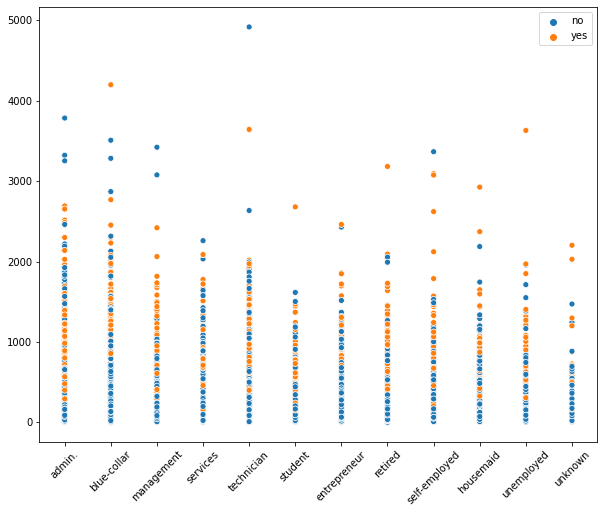

In [86]:
plt.figure(figsize = (10,8))
sns.scatterplot(x = job, y = duration, hue = y)
plt.xticks(rotation=45)
plt.show()

- Job rispetto al target

In [87]:
# Splittiamo in due liste chiave, valore per fare plot
def split_k_v(query):
    return query.rdd.map(lambda x: x[0] + "_"+x[1]).collect(), query.rdd.map(lambda x: x[1]).collect(), query.rdd.map(lambda x: x[2]).collect() 

In [88]:
not_duplicated_df.createOrReplaceTempView("temp_my")

In [89]:
my = spark.sql("SELECT job, y, count(*) AS tot FROM temp_my GROUP BY job, y")
my.show()

+-------------+---+----+
|          job|  y| tot|
+-------------+---+----+
|       admin.| no|9067|
|      retired|yes| 434|
|   management| no|2595|
|  blue-collar| no|8613|
|      student| no| 600|
|      unknown| no| 293|
|   technician| no|6009|
|       admin.|yes|1351|
|   management|yes| 328|
|  blue-collar|yes| 638|
|      unknown|yes|  37|
|   unemployed| no| 870|
|self-employed|yes| 149|
|   unemployed|yes| 144|
|    housemaid|yes| 106|
|   technician|yes| 730|
|     services|yes| 323|
|self-employed| no|1272|
|    housemaid| no| 954|
| entrepreneur|yes| 124|
+-------------+---+----+
only showing top 20 rows



In [90]:
temp_df = my.toPandas()

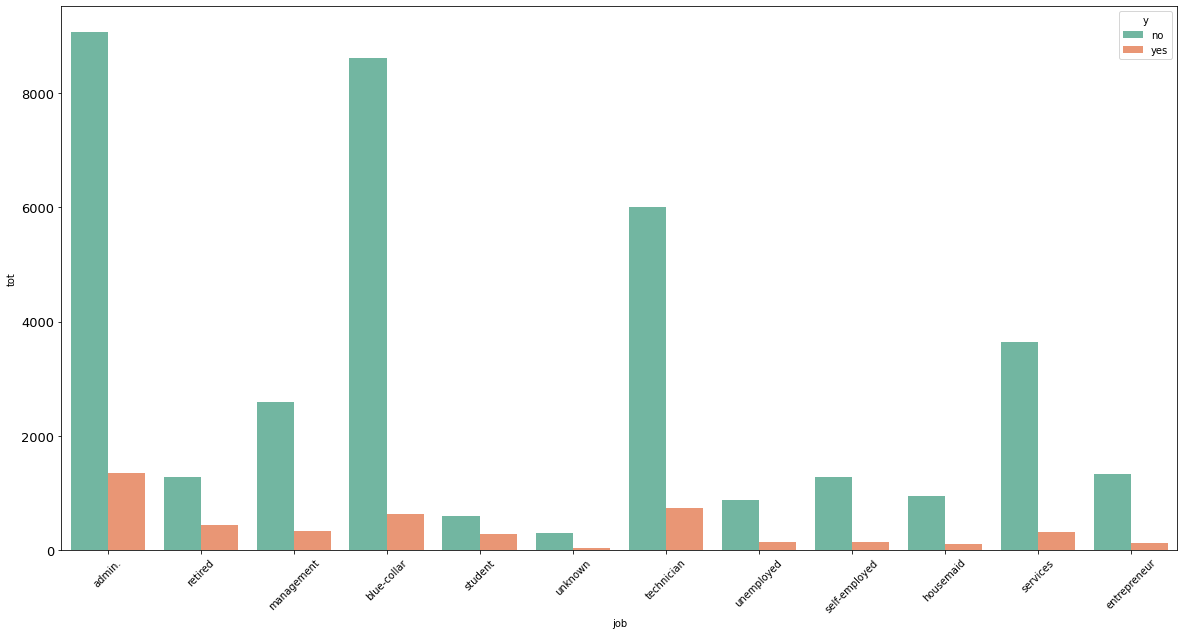

In [91]:

plt.figure(figsize = (20,10))
sns.barplot(x = "job", y = "tot", hue = "y", data  = temp_df, palette="Set2")
plt.xticks(rotation=45, fontsize='10')
plt.yticks(fontsize='13')
plt.show()


- Distribuzione età

In [92]:
def split_k_v(query):
    return query.rdd.map(lambda x: x[0]).collect(),query.rdd.map(lambda x: x[1]).collect() 

In [93]:
not_duplicated_df.createOrReplaceTempView("temp3")

In [94]:
age = spark.sql("SELECT age, count(*) AS tot FROM temp3 GROUP BY age")
age.show()

+---+----+
|age| tot|
+---+----+
| 31|1946|
| 85|  15|
| 65|  44|
| 53| 732|
| 78|  27|
| 34|1745|
| 81|  20|
| 28|1001|
| 76|  34|
| 27| 850|
| 26| 698|
| 44|1011|
| 91|   2|
| 22| 137|
| 47| 927|
| 52| 779|
| 86|   8|
| 40|1161|
| 20|  65|
| 94|   1|
+---+----+
only showing top 20 rows



L'istogramma dell'età mostra una ditribuzione molto simile a una distribuzione normale, benché inclinata a destra

In [95]:
age_k, age_v = split_k_v(age)

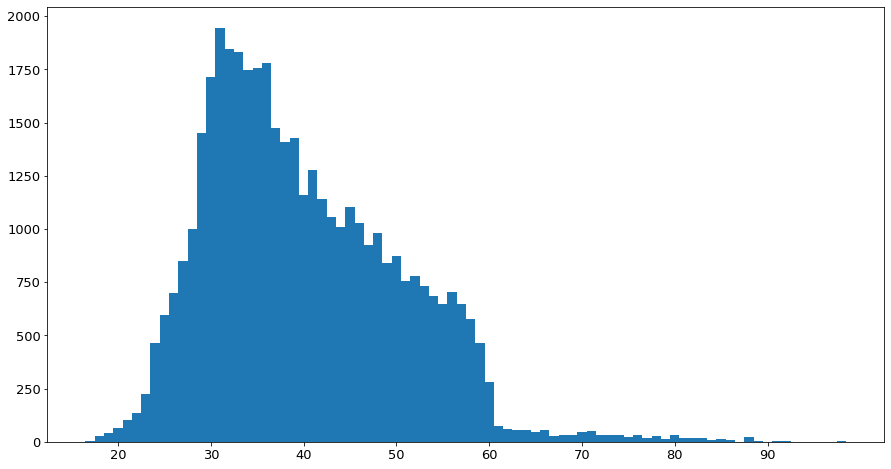

In [96]:
#sns.set(style="whitegrid", palette="deep")
plt.figure(figsize=(15,8))
plt.xticks(range(0,100, 10), rotation=0, fontsize='13')
plt.yticks(fontsize='13')
plt.bar(age_k, age_v,width=1)
plt.show()

# Analisi dei dati economici

In [97]:
emp_var_rate = kdd_df.rdd.map(lambda x: x.emp_var_rate).collect()
cons_price_idx = kdd_df.rdd.map(lambda x: x.cons_price_idx).collect()
euribor3m = kdd_df.rdd.map(lambda x: x.euribor3m).collect()
nr_employed = kdd_df.rdd.map(lambda x: x.nr_employed).collect()

euribor3m - nr_employed

Vediamo dal plot come all'aumento dei tassi di interesse euribor (sulle x) anche il numero di dipendenti dell'azienda aumenta (asse delle y)

Il tasso di interesse Euribor a 3 mesi è il tasso di interesse al quale una selezione di banche europee si prestano reciprocamente fondi denominati in euro, per cui i prestiti hanno una scadenza di 3 mesi.

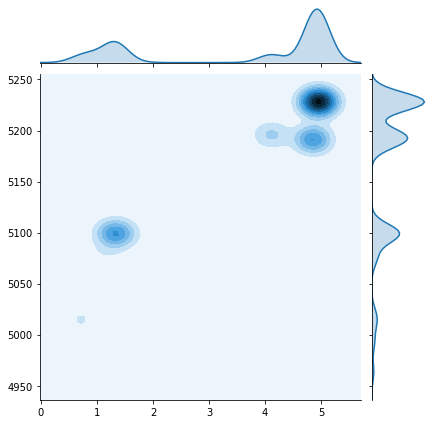

In [98]:
sns.jointplot(x = euribor3m, y = nr_employed, kind = 'kde')

euribor3m - emp_var_rate 

All'aumentare dei tassi di interesse euribor, aumenta anche il tasso di variazione dei dipendenti (conseguenza del precedente plot)

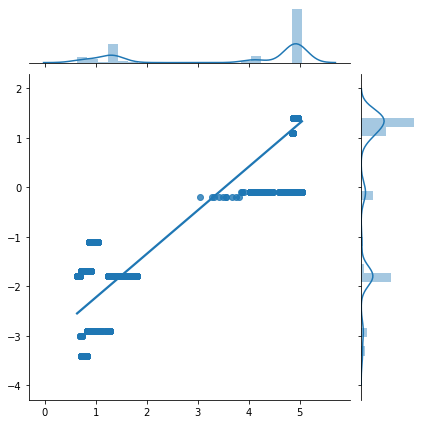

In [99]:
sns.jointplot(x = euribor3m, y = emp_var_rate, kind = 'reg')

nr_employed - cons_price_idx 

Maggiore è il numero di dipendenti, maggiore è l'indice dei prezzi al consumo

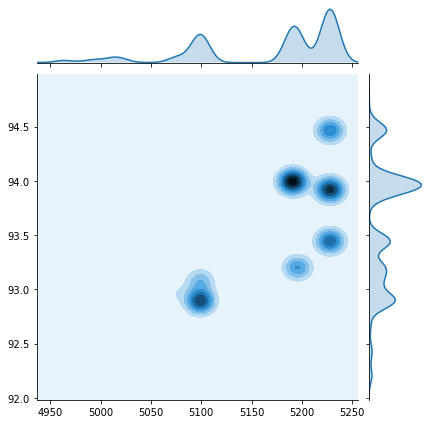

In [100]:
sns.jointplot(x = nr_employed, y = cons_price_idx, kind = 'kde')

Confronto tra month_year e emp_var_rate

è possibile vedere come per il 2008 i mesi estivi hanno un alto tasso di occupazione
Dopo le fluttuazioni di settembre e ottobre, l'occupazione si è ridotta verso la fine dell'anno. Spiega il piccolo aumento di novembre e il calo di dicembre.

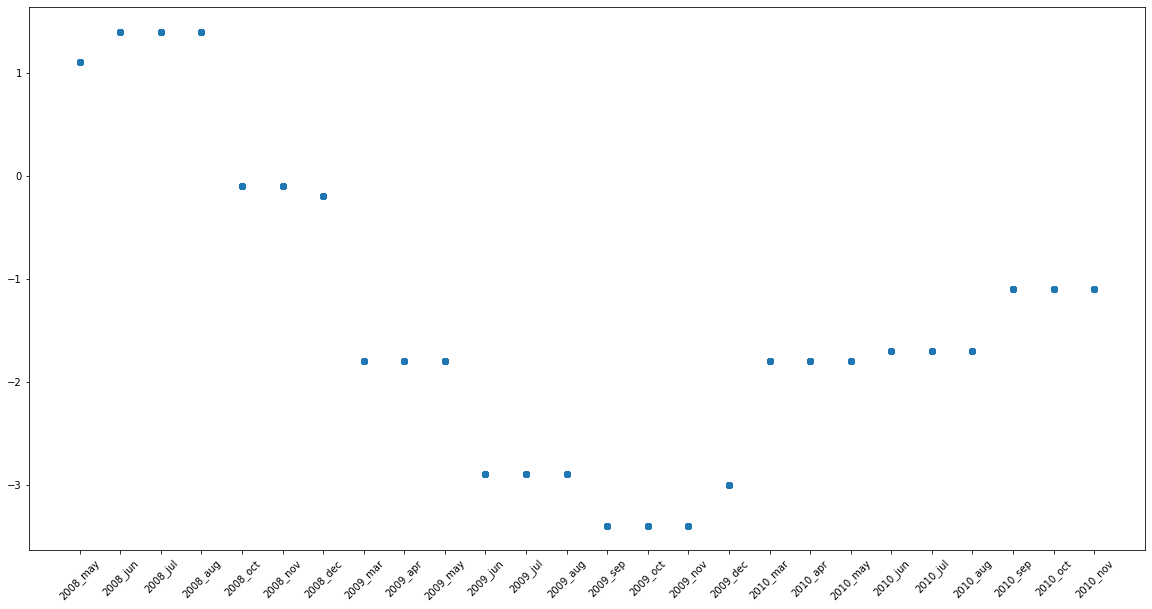

In [101]:
fig, ax = plt.subplots(figsize=(20,10))
plt.xticks(rotation=45)
ax.scatter(month_year, emp_var_rate)

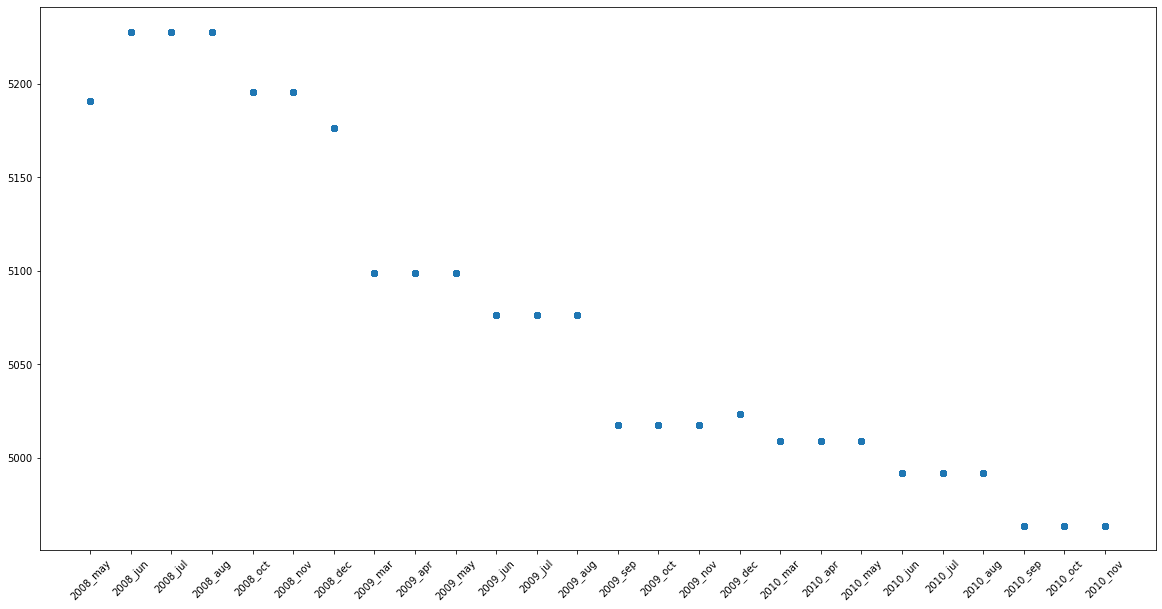

In [102]:
fig, ax = plt.subplots(figsize=(20,10))
plt.xticks(rotation=45)
ax.scatter(month_year, nr_employed)

## Conteggio Missing Values
- Nel dataset i Missing Values sono specificati come "unknown"

In [103]:
kdd_df.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('month', 'string'),
 ('day_of_week', 'string'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('emp_var_rate', 'double'),
 ('cons_price_idx', 'double'),
 ('cons_conf_idx', 'double'),
 ('euribor3m', 'double'),
 ('nr_employed', 'double'),
 ('y', 'string')]

In [ ]:
### for col in (y for y in kdd_df.dtypes if y[1]=="string"):
    print("<" + str(col[0])+"> " + " with null values = " +str(kdd_df.filter(kdd_df[col[0]] == "unknown").count()))

## Replace Missing Values (Prova Non Usata)

In [105]:
# Fare il replace di particolari valori in determiante colonne
# inserire in "lit()" il valore che vogliamo inserire
# df = kdd_0df.withColumn("loan", when(kdd_df["loan"]=="unknown", 
#                                     lit(notckd)).otherwise(kdd_df["loan"]))

Per sostituire i valori nulli con la moda:

In [106]:
# Colonne con valori nulli
num_col = ["job", "marital", "education", "default", "housing", "loan"]

In [107]:
def fill_mode(df, cols_to_replace):
    mode_col = []
    for c in cols_to_replace:
        # Filtrare i nulli
        df = df.filter(df[c] != "unknown")
        # Selezione valori distinti
        distinct_val = df.select(c).distinct().rdd.map(lambda x: x[0]).collect()
        # Contatore dei valori distinti
        distinct_count = []
        for v in distinct_val:
            distinct_count.append([v, df.filter(df[c]==v).count()])
        # Ordiniamo
        s_distinct_count = sorted(distinct_count, key = lambda x: x[1], reverse = True)

        mode_col.append([c, s_distinct_count[0][0]])
    for c, m in mode_col:
        df = df.withColumn(c, when(df[c]=="unknown", lit(m)).otherwise(df[c]))
    return df

In [108]:
df = fill_mode(kdd_df, num_col)

In [109]:
for col in (y for y in df.dtypes if y[1]=="string"):
    print("<" + str(col[0])+"> " + " with null values = " +str(df.filter(df[col[0]] == "unknown").count()))

<job>  with null values = 0
<marital>  with null values = 0
<education>  with null values = 0
<default>  with null values = 0
<housing>  with null values = 0
<loan>  with null values = 0
<contact>  with null values = 0
<month>  with null values = 0
<day_of_week>  with null values = 0
<poutcome>  with null values = 0
<y>  with null values = 0


## Outliers Detection

Prova differenza tra kdd_df (dove PDays ha molti valoti a 999) e not_duplicated_df (dove in PDays il 999 è stato sostituito con -1)

In [110]:
numerical_features = [x[0] for x in kdd_df.dtypes if x[1]== "int" ]

In [111]:
def outliers_plot(features, df):
    for i in features:
        fig1, ax1 = plt.subplots()
        ax1.set_title('Feature = '+ str(i))
        ax1.boxplot(df.select(i).rdd.map(lambda r: r[0]).collect())

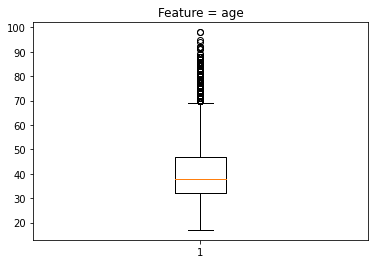

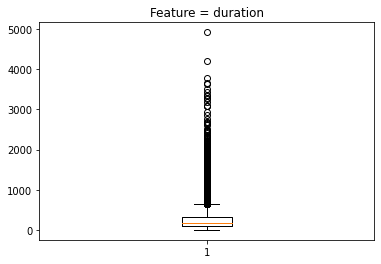

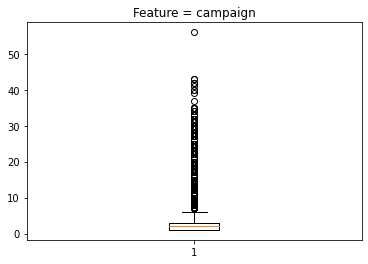

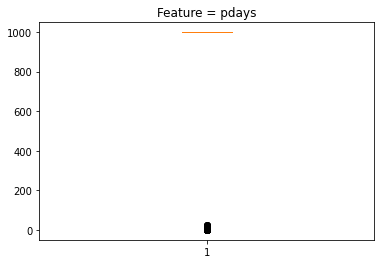

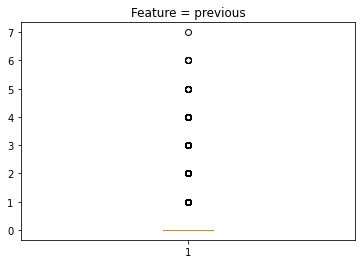

In [112]:
outliers_plot(numerical_features, kdd_df)

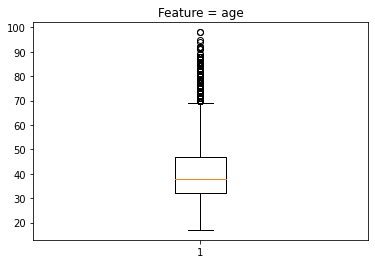

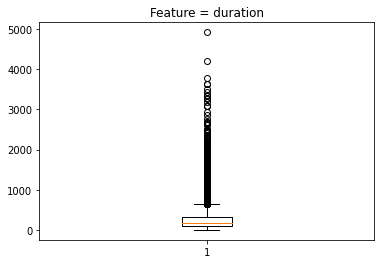

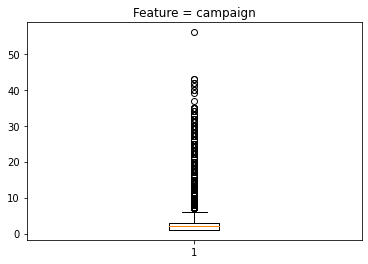

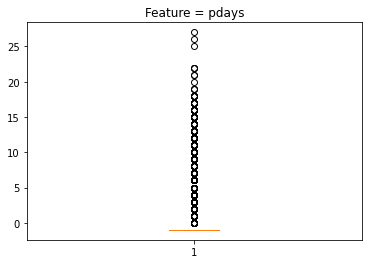

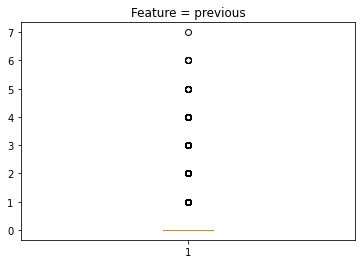

In [113]:
outliers_plot(numerical_features, not_duplicated_df)

Il quartile IQR viene calcolato come il valor medio tra il quartile inferiore e superiore dei dati
come il medio, il quartile inferiore e superiore può essere calcolato con "percentile()" inserendo 50%, 25%, 75%

Un valore anomalo viene classificato come tale se si discosta per certa quantità di IQR dal valore mediano di solito pari a 
2.22 (cioè 3 deviazioni standard)

In [114]:
class df_Outlier():
    def __init__(self, dataframe):
        self.dataframe = dataframe
        
    # Calcoliamo gli intervalli creando un dizionario bounds
    # bound = {features : [Q1, Q3, lower, upper]}
    def interquart_range(self):
        bounds = {
            feature: dict(
                    zip(["Q1", "Q3"], self.dataframe.approxQuantile(feature, [0.25, 0.75], 0))
                )
            for feature, f_type in zip(self.dataframe.columns, self.dataframe.dtypes) if f_type[1] == "int"            
        }
        for b in bounds:
            print(b)
            IQR = bounds[b]["Q3"] - bounds[b]["Q1"]
            bounds[b]["lower"] = bounds[b]["Q1"] - (IQR * 2.5)
            print("Lower = " + str(bounds[b]["Q1"] - (IQR * 2.5)))
            bounds[b]["upper"] = bounds[b]["Q3"] + (IQR * 2.5)
            print("Upper = " + str(bounds[b]["Q3"] + (IQR * 2.5)))
        return bounds
    
    def print_interquart(self):
        self.interquart_range()
        
    # Per ogni features intera calcoliamo se è un outliers o meno e aggiungiamo una colonna "nameclass_out"
    def flag_out(self):
        bounds = self.interquart_range()
        return self.dataframe.select(
            "*",
            *[
                F.when(
                    F.col(c).between(bounds[c]['lower'], bounds[c]['upper']),
                    0
                ).otherwise(1).alias(c+"_out") 
                for c in bounds
            ]
        )
    
    # Mostriamo gli outliers
    def show_out(self):
        out_dataframe = self.flag_out()
        for o in out_dataframe.columns:
            out_dataframe.select(o).filter(F.col(o).isNotNull()).show()
            
    def select_not_out(self):
        out_dataframe = self.flag_out()
        out_dataframe.createOrReplaceTempView("temp")
        new_df = self.dataframe.select("*")
        #new_df = copy.deepcopy(self.dataframe.schema)
        for c in out_dataframe.columns:
            if "_out" in c:
                new_df= spark.sql("SELECT * FROM temp WHERE " + str(c) + "= 0")
        return new_df

In [115]:
new_df = df_Outlier(not_duplicated_df).select_not_out()

age
Lower = -5.5
Upper = 84.5
duration
Lower = -440.5
Upper = 861.5
campaign
Lower = -4.0
Upper = 8.0
pdays
Lower = -1.0
Upper = -1.0
previous
Lower = 0.0
Upper = 0.0


In [116]:
new_df.createOrReplaceTempView("temp")
count = spark.sql("SELECT COUNT(*) FROM temp")
count.show()

+--------+
|count(1)|
+--------+
|   35547|
+--------+



## Correlation Matrix

### Pearson

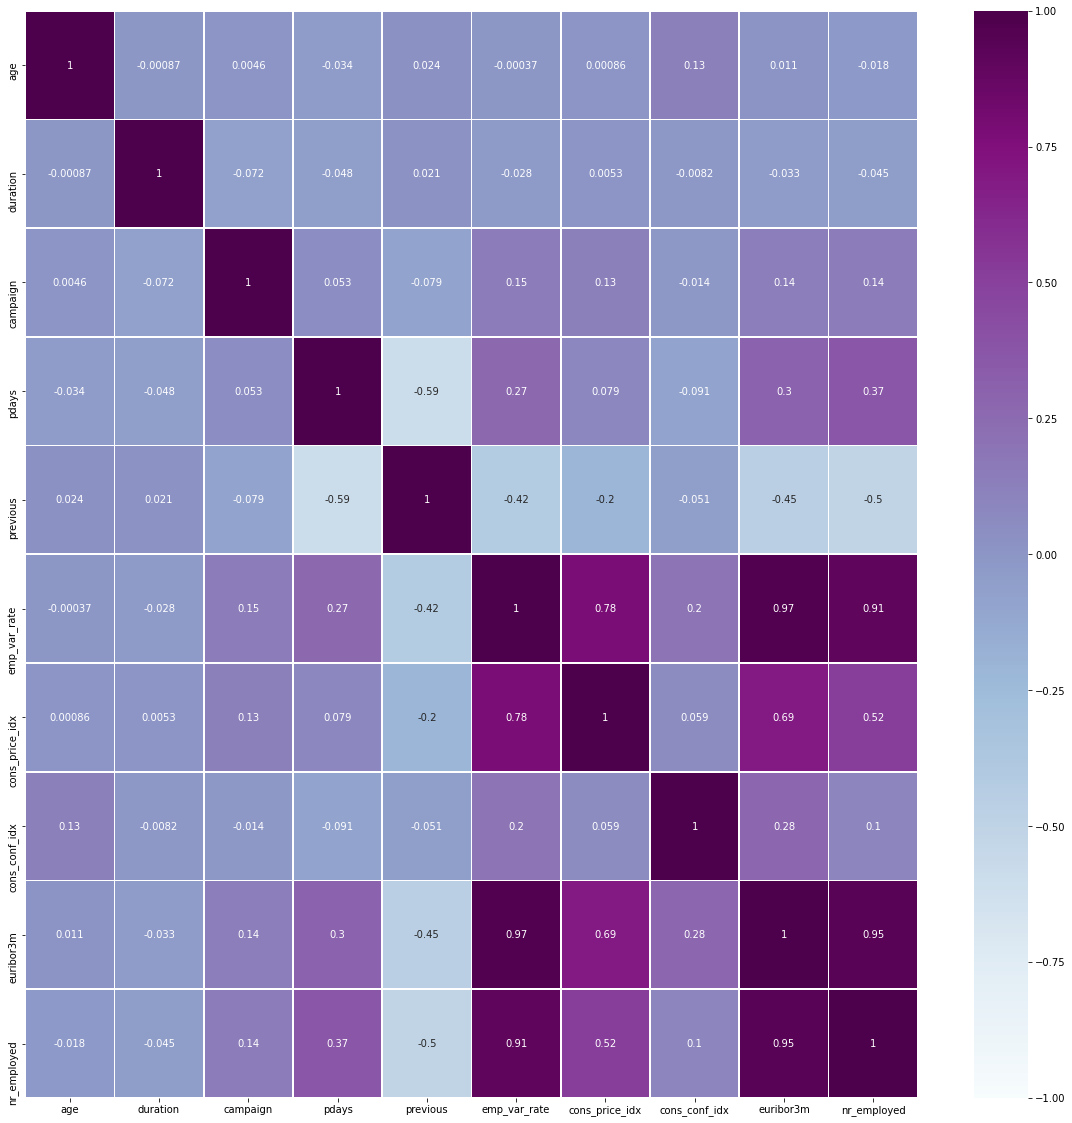

In [117]:
col_names = [x[0] for x in kdd_df.dtypes if x[1]=="int" or x[1]=="double"]
features = kdd_df.select(col_names).rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names
plt.figure(figsize = (20,20))
correlation = sns.heatmap(corr_df, cmap='BuPu', vmin=-1, vmax=1,annot=True, linewidths=.7)

### not_duplicated_df

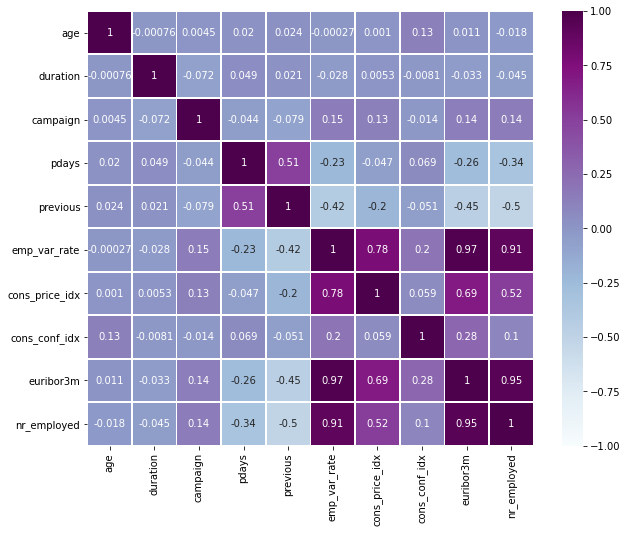

In [121]:
col_names = [x[0] for x in not_duplicated_df.dtypes if x[1]=="int" or x[1]=="double"]
features = not_duplicated_df.select(col_names).rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, )
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names
plt.figure(figsize = (10,8))
correlation = sns.heatmap(corr_df, cmap='BuPu', vmin=-1, vmax=1,annot=True, linewidths=.7)

# Normalizzazione - One Hot (Prova Non Usata)

In [454]:
# One Hot
kdd_train_df_ohe_normalized = kdd_train_df_num.map(lambda x : NormalizeAndOneHotEncoding(x))

'\nassembler = VectorAssembler().setInputCols            (df_new.columns).setOutputCol("features")\ntransformed = assembler.transform(df_new)\nscaler = MinMaxScaler(inputCol="features",         outputCol="scaledFeatures")\nscalerModel =  scaler.fit(transformed.select("features"))\nscaledData = scalerModel.transform(transformed)'

## Scrittura nuovo csv

In [ ]:
kdd_df.write.format("csv").save("hdfs://kddrtserver13.isti.cnr.it:9000/user/hpsa15/n_dataset.csv")

In [ ]:
spark.stop()